In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [180]:
import datetime
import numpy as np
df = pd.read_csv("./dataset.csv", index_col=0)
df.head()
df["time_to_checkout"] = df["time_to_checkout"].map(
    lambda x: pd.to_timedelta(x))
df["time_to_checkout_hours"] = df["time_to_checkout"].map(
    lambda x: x/np.timedelta64(1, 'h'))
df.head()

,customer_id,actions,start_time,end_time,time_to_checkout,trade_order,hesitate,time_to_checkout_hours
0,++2zeaFx0ku6BVmoPrul6jYI0HWXWIq/ZZvT+tNNtKX66B...,"['viewmainpage', 'viewmainpage', 'selectconten...",2023-10-10 14:26:07.546,2023-10-11 09:45:41.725,0 days 19:19:34.179000,ybo/HZA5dh8Z5lNbvB3Bvw==,0,19.326161
5,++3PkM5EUwks6JiI4er8ae7xOjBmP7hcRsBkbdFtodN+YI...,"['viewmainpage', 'viewmainpage', 'selectconten...",2023-10-12 22:13:58.001,2023-10-12 22:22:52.295,0 days 00:08:54.294000,+/QxHhxQwQZ5bsd+9xMIhQ==,0,0.148415
10,++QZAN6YFZwgP6lpxxy5F/5lgowHqpu1rBpaR7NlZtROjY...,"['viewmainpage', 'selectcontent', 'viewmainpag...",2023-10-12 15:26:10.577,2023-10-13 21:57:57.278,1 days 06:31:46.701000,KDcZFvHQdaIrAv/zSdMAUw==,0,30.529639
14,++c39Ct12j1d9kxneNe/hqfZu0Sgv0Q1sMOuk/S7YMefYb...,"['viewmainpage', 'selectcontent', 'viewcustomp...",2023-10-11 00:59:47.652,2023-10-11 01:19:02.542,0 days 00:19:14.890000,nuASYFpXipf1DwjEKoOTBQ==,0,0.320803
17,++c39Ct12j1d9kxneNe/hqfZu0Sgv0Q1sMOuk/S7YMefYb...,"['viewmainpage', 'selectcontent', 'viewmainpag...",2023-10-11 01:19:02.542,2023-10-14 20:34:24.110,3 days 19:15:21.568000,hakVAD9yC0irQY94TY/6cA==,0,91.255991


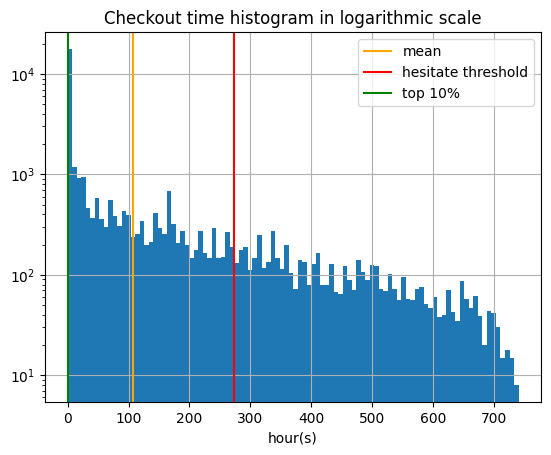

In [239]:
df.hist(column="time_to_checkout_hours", bins=100, log=True)
plt.xlabel("hour(s)")
plt.title("Checkout time histogram in logarithmic scale")
plt.axvline(x=df["time_to_checkout_hours"].mean(),label="mean" , color="orange")
plt.axvline(x=df["time_to_checkout_hours"].mean()+df["time_to_checkout_hours"].std(),label="hesitate threshold" , color="red")
plt.axvline(x=df["time_to_checkout_hours"].quantile(0.1), label="top 10%", color="green")
plt.legend()

In [252]:
actions = ["register", "viewmainpage", "viewcategory", "viewactivity", "viewcustompage", "viewalbumdetail", "viewvideodetail", "viewarticledetail",
           "viewecoupondetail", "viewpromotiondetail", "viewcoupondetail", "viewproduct", "search", "add", "checkout", "purchase", "selectcontent"]
actions = {k: v for v, k in enumerate(actions)}
n_actions = len(actions)
print("Action count:", n_actions)

Action count: 17


In [257]:
import torch


def action_to_index(action):
    return actions[action]


def sequence_to_tensor(sequence):
    tensor = torch.zeros(len(sequence), 1, n_actions)
    for index, action in enumerate(sequence):
        tensor[index][0][action_to_index(action)] = 1
    return tensor


def label_to_tensor(label: int):
    tensor = torch.nn.functional.one_hot(
        torch.tensor(label), 2)  # binary classification
    return tensor

In [258]:
import torch.nn as nn
import torch.nn.functional as F


class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

normal: 30767 hesitate: 5702


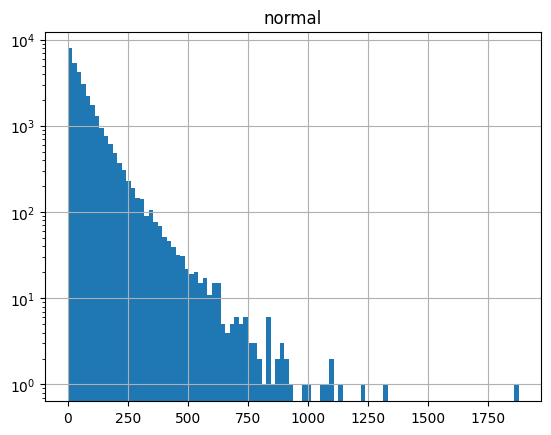

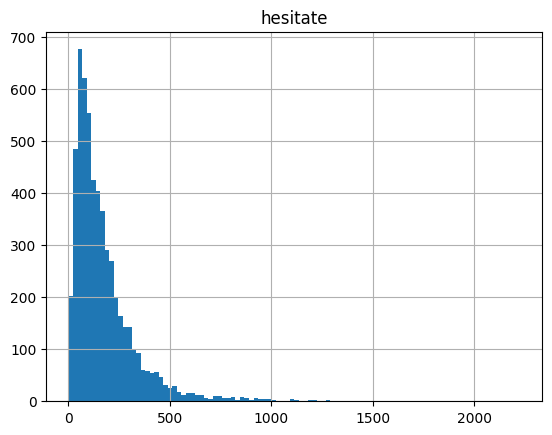

In [259]:
import random
import ast
random.seed(42)

df["actions_length"] = df["actions"].apply(lambda x: len(ast.literal_eval(x)))

normal_df = df[df["hesitate"] == 0]
hesitate_df = df[df["hesitate"] == 1]

print("normal:", len(normal_df.index), "hesitate:", len(hesitate_df.index))


normal_df.hist(column=["actions_length"],  bins=100, log=True)
plt.title("normal")
hesitate_df.hist(column=["actions_length"], bins=100, log=False)
plt.title("hesitate")

train_df = pd.concat([normal_df[:5000], hesitate_df[:5000]])
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

test_df = pd.concat([normal_df[5000:5100], hesitate_df[5000:5100]])

In [276]:
from tqdm import tqdm
input_size = len(actions)
hidden_size = 64
num_layers = 4
output_size = 2
model = LSTMClassifier(input_size, hidden_size,
                       num_layers, output_size).to("cuda")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    for _, sample in tqdm(train_df.iterrows(), total=len(train_df.index), desc=f"Training on epoch {epoch+1}"):
        optimizer.zero_grad()
        sequence_tensor = sequence_to_tensor(
            ast.literal_eval(sample["actions"]))
        sequence_tensor = sequence_tensor.to("cuda")
        if (len(sequence_tensor) == 0):
            continue
        sequence_tensor = torch.reshape(sequence_tensor, (1, -1, input_size))
        outputs = model(sequence_tensor)
        label_tensor = label_to_tensor(sample["hesitate"])
        label_tensor = label_tensor.to(
            "cuda", dtype=torch.float64).reshape((1, 2))
        loss = criterion(outputs, label_tensor)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
    total = len(test_df.index)
    correct = 0
    for _, row in tqdm(test_df.iterrows(), total=len(test_df.index),  desc="Evaluating model performace"):
        sequence_tensor = sequence_to_tensor(
            ast.literal_eval(row["actions"]))
        if (len(sequence_tensor) == 0):
            total -= 1
            continue
        sequence_tensor = sequence_tensor.to(
            "cuda").reshape((1, -1, input_size))

        with torch.no_grad():
            predicted_tensor = model(sequence_tensor)
        predicted = predicted_tensor.argmax()
        if predicted == row["hesitate"]:
            correct += 1
    print(f"Accuracy:{correct / total:.2f}",)

Training on epoch 1:   0%|          | 17/10000 [00:00<01:01, 163.35it/s]

Training on epoch 1: 100%|██████████| 10000/10000 [00:55<00:00, 181.46it/s]


Epoch [1/10], Loss: 0.6432794332504272


Evaluating model performace: 100%|██████████| 200/200 [00:00<00:00, 345.66it/s]


Accuracy:0.51


Training on epoch 2: 100%|██████████| 10000/10000 [00:56<00:00, 178.30it/s]


Epoch [2/10], Loss: 0.5842759609222412


Evaluating model performace: 100%|██████████| 200/200 [00:00<00:00, 430.21it/s]


Accuracy:0.51


Training on epoch 3: 100%|██████████| 10000/10000 [00:56<00:00, 175.73it/s]


Epoch [3/10], Loss: 0.4717289209365845


Evaluating model performace: 100%|██████████| 200/200 [00:00<00:00, 518.94it/s]


Accuracy:0.72


Training on epoch 4: 100%|██████████| 10000/10000 [00:54<00:00, 184.30it/s]


Epoch [4/10], Loss: 0.23734882473945618


Evaluating model performace: 100%|██████████| 200/200 [00:00<00:00, 370.53it/s]


Accuracy:0.71


Training on epoch 5: 100%|██████████| 10000/10000 [00:53<00:00, 186.44it/s]


Epoch [5/10], Loss: 0.14765016734600067


Evaluating model performace: 100%|██████████| 200/200 [00:00<00:00, 495.03it/s]


Accuracy:0.77


Training on epoch 6: 100%|██████████| 10000/10000 [00:52<00:00, 190.22it/s]


Epoch [6/10], Loss: 0.9664332866668701


Evaluating model performace: 100%|██████████| 200/200 [00:00<00:00, 356.05it/s]


Accuracy:0.72


Training on epoch 7: 100%|██████████| 10000/10000 [00:57<00:00, 173.37it/s]


Epoch [7/10], Loss: 1.456765055656433


Evaluating model performace: 100%|██████████| 200/200 [00:00<00:00, 451.42it/s]


Accuracy:0.62


Training on epoch 8: 100%|██████████| 10000/10000 [00:57<00:00, 173.11it/s]


Epoch [8/10], Loss: 0.5437828302383423


Evaluating model performace: 100%|██████████| 200/200 [00:00<00:00, 519.35it/s]


Accuracy:0.70


Training on epoch 9: 100%|██████████| 10000/10000 [00:53<00:00, 186.49it/s]


Epoch [9/10], Loss: 0.378082275390625


Evaluating model performace: 100%|██████████| 200/200 [00:00<00:00, 335.67it/s]


Accuracy:0.75


Training on epoch 10: 100%|██████████| 10000/10000 [00:55<00:00, 178.59it/s]


Epoch [10/10], Loss: 0.163670614361763


Evaluating model performace: 100%|██████████| 200/200 [00:00<00:00, 388.23it/s]

Accuracy:0.77


In [278]:
def predict(row):
    sequence_tensor = sequence_to_tensor(
        ast.literal_eval(row["actions"]))
    if (len(sequence_tensor) == 0):
        print("warning: action sequence length == 0")
        return
    sequence_tensor = sequence_tensor.to(
        "cuda").reshape((1, -1, input_size))

    with torch.no_grad():
        predicted_tensor = model(sequence_tensor)
    predicted = predicted_tensor.argmax()
    print("user actions:", row["actions"],
          "predicted behavior:", "hesitate" if predicted == 1 else "normal")


for _, row in test_df.sample(n=10).iterrows():
    predict(row)

user actions: ['selectcontent', 'viewmainpage', 'viewmainpage', 'selectcontent', 'viewecoupondetail', 'selectcontent', 'viewecoupondetail', 'selectcontent', 'selectcontent', 'selectcontent', 'selectcontent', 'selectcontent', 'selectcontent', 'selectcontent', 'selectcontent', 'viewmainpage', 'selectcontent', 'selectcontent', 'selectcontent', 'selectcontent', 'selectcontent', 'viewmainpage', 'selectcontent', 'selectcontent', 'selectcontent', 'selectcontent', 'viewmainpage', 'viewmainpage', 'selectcontent', 'selectcontent', 'selectcontent', 'viewmainpage', 'selectcontent', 'viewmainpage', 'selectcontent', 'viewmainpage', 'selectcontent', 'selectcontent', 'selectcontent', 'selectcontent', 'viewecoupondetail', 'viewecoupondetail', 'viewecoupondetail', 'viewproduct', 'add', 'selectcontent', 'viewmainpage', 'selectcontent', 'selectcontent', 'selectcontent', 'checkout', 'selectcontent', 'selectcontent', 'selectcontent', 'selectcontent', 'viewmainpage', 'selectcontent', 'viewmainpage', 'selectc

In [280]:
print("LSTM Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

LSTM Model's state_dict:
lstm.weight_ih_l0 	 torch.Size([256, 17])
lstm.weight_hh_l0 	 torch.Size([256, 64])
lstm.bias_ih_l0 	 torch.Size([256])
lstm.bias_hh_l0 	 torch.Size([256])
lstm.weight_ih_l1 	 torch.Size([256, 64])
lstm.weight_hh_l1 	 torch.Size([256, 64])
lstm.bias_ih_l1 	 torch.Size([256])
lstm.bias_hh_l1 	 torch.Size([256])
lstm.weight_ih_l2 	 torch.Size([256, 64])
lstm.weight_hh_l2 	 torch.Size([256, 64])
lstm.bias_ih_l2 	 torch.Size([256])
lstm.bias_hh_l2 	 torch.Size([256])
lstm.weight_ih_l3 	 torch.Size([256, 64])
lstm.weight_hh_l3 	 torch.Size([256, 64])
lstm.bias_ih_l3 	 torch.Size([256])
lstm.bias_hh_l3 	 torch.Size([256])
fc.weight 	 torch.Size([2, 64])
fc.bias 	 torch.Size([2])


In [282]:
torch.save(model.state_dict(), "./model.bin")

In [283]:
# load model
loaded_model = LSTMClassifier(input_size, hidden_size,
                              num_layers, output_size).to("cuda")
loaded_model.load_state_dict(torch.load("./model.bin"))
loaded_model.eval()

LSTMClassifier(
  (lstm): LSTM(17, 64, num_layers=4, batch_first=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)